In [15]:
%matplotlib inline
# %config InlineBackend.figure_format='retina' 
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. 
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [8]:
df = pd.read_csv('WAG_C_M.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [9]:
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


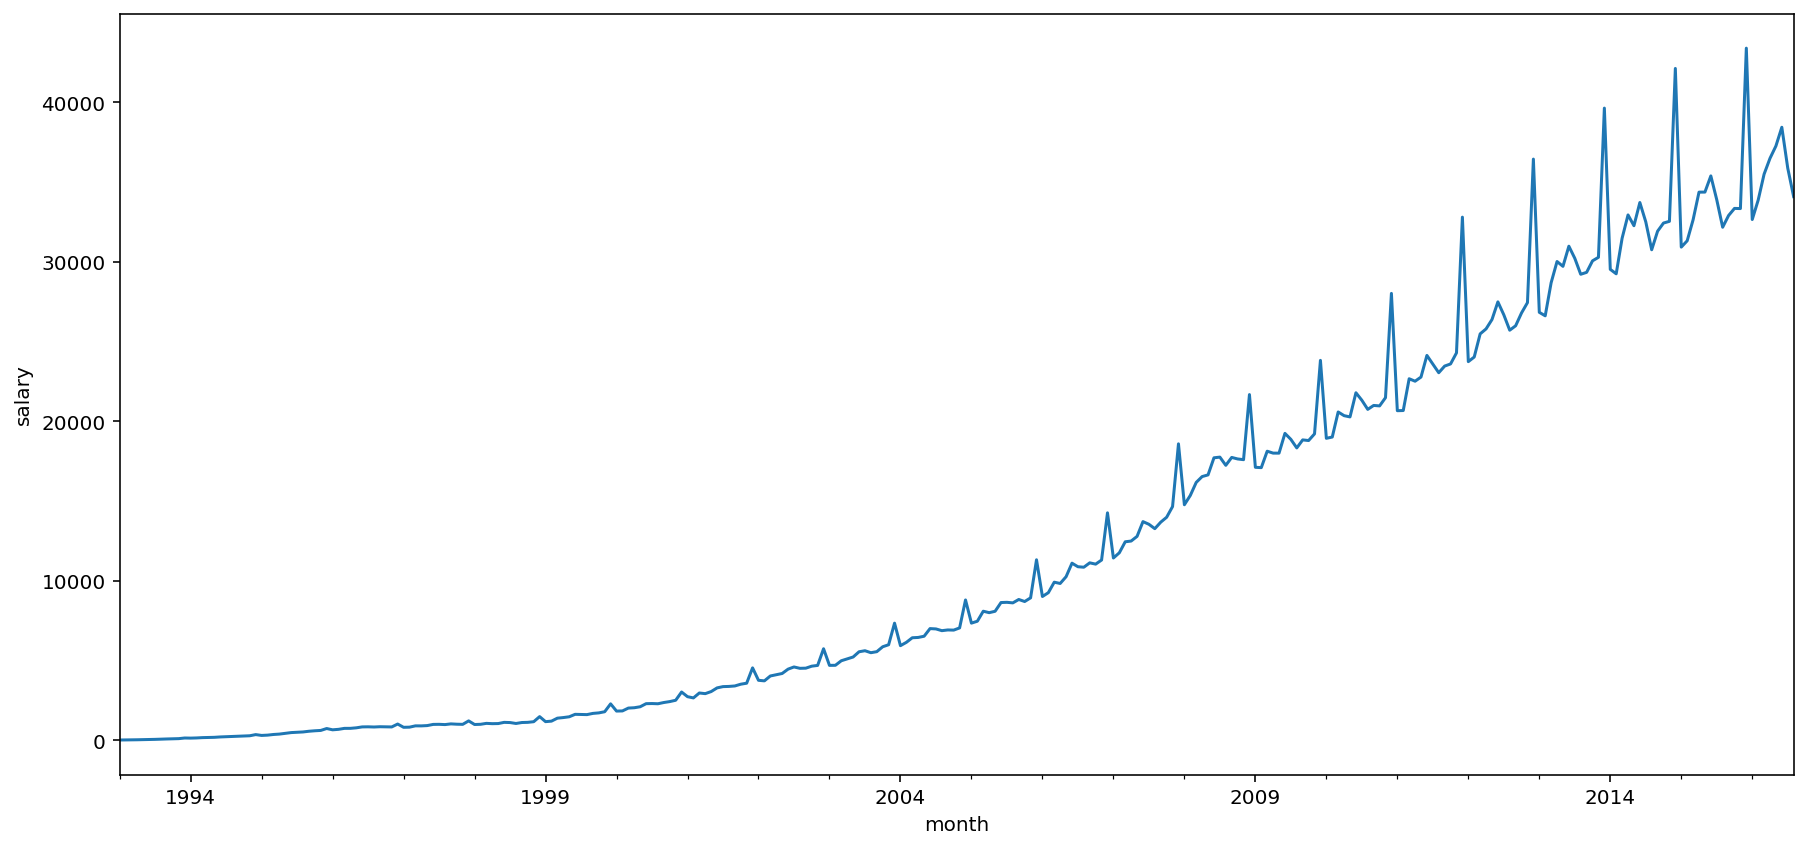

In [16]:
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.ylabel('salary')
pylab.show()

В данных прослеживается явный тренд и сезонность.
Воспользуемся STL-декомпозицией, чтоб посмотреть на временной ряд внимательнее

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

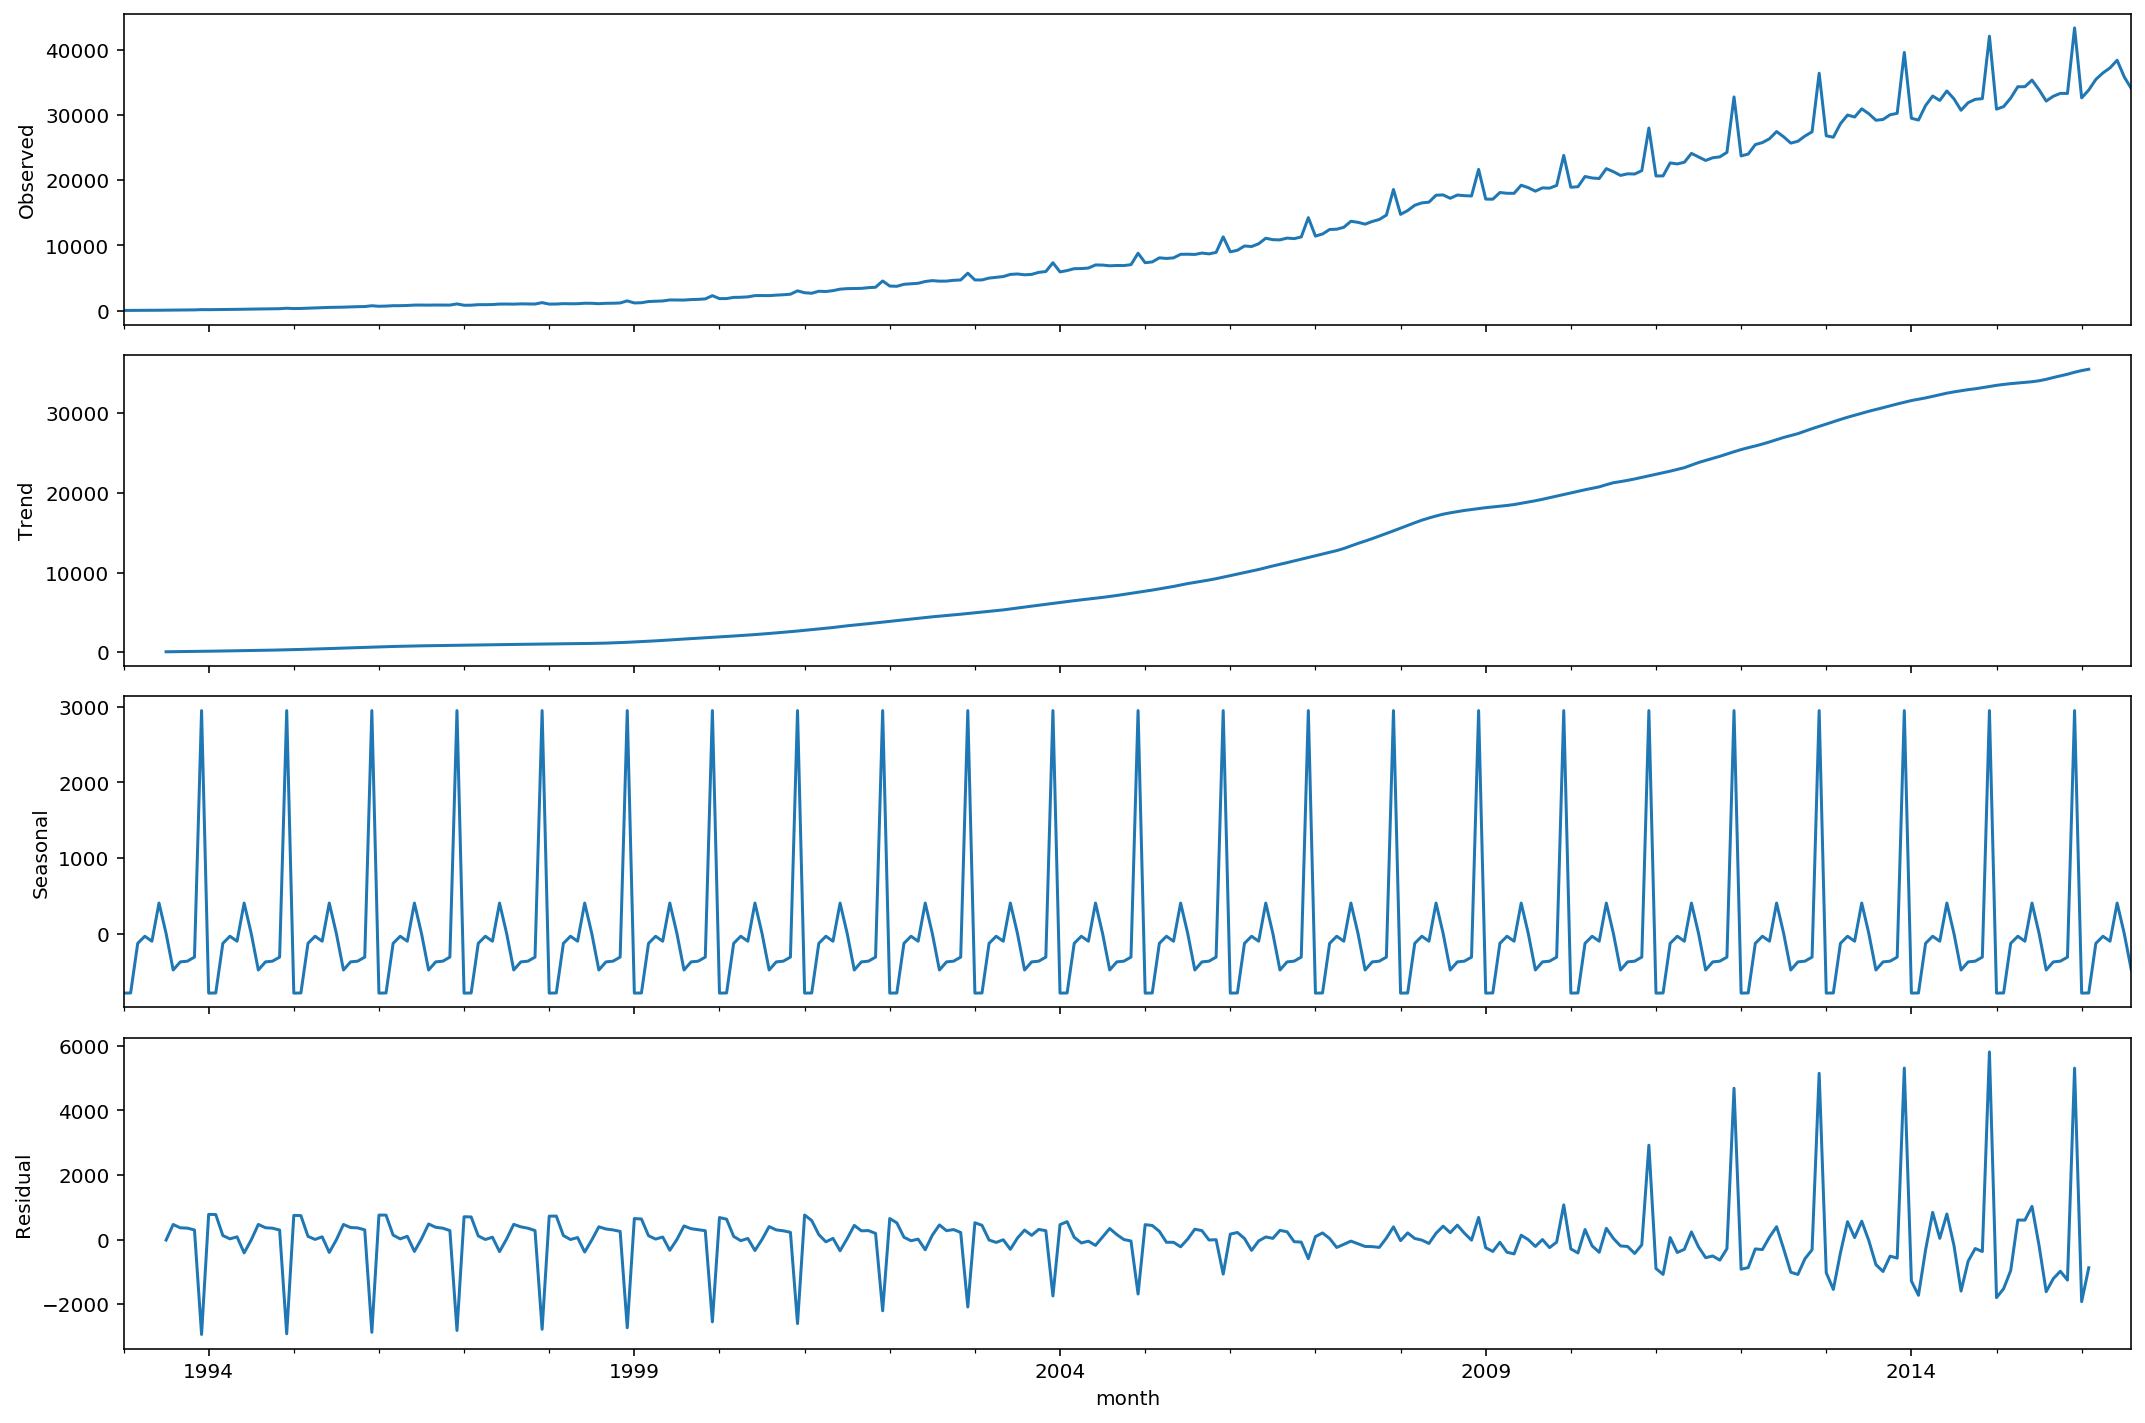

In [17]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

На декомпозиции мы наблюдаем и явный тренд и сезонность и большой разброс ошибок. Критерий Дики-Фуллера не отвергает гипотезу о НЕстационарности ряда, что было ясно и визуально. Воспользуемся преобразованием Бокса-Кокса для стабилизации дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.991850


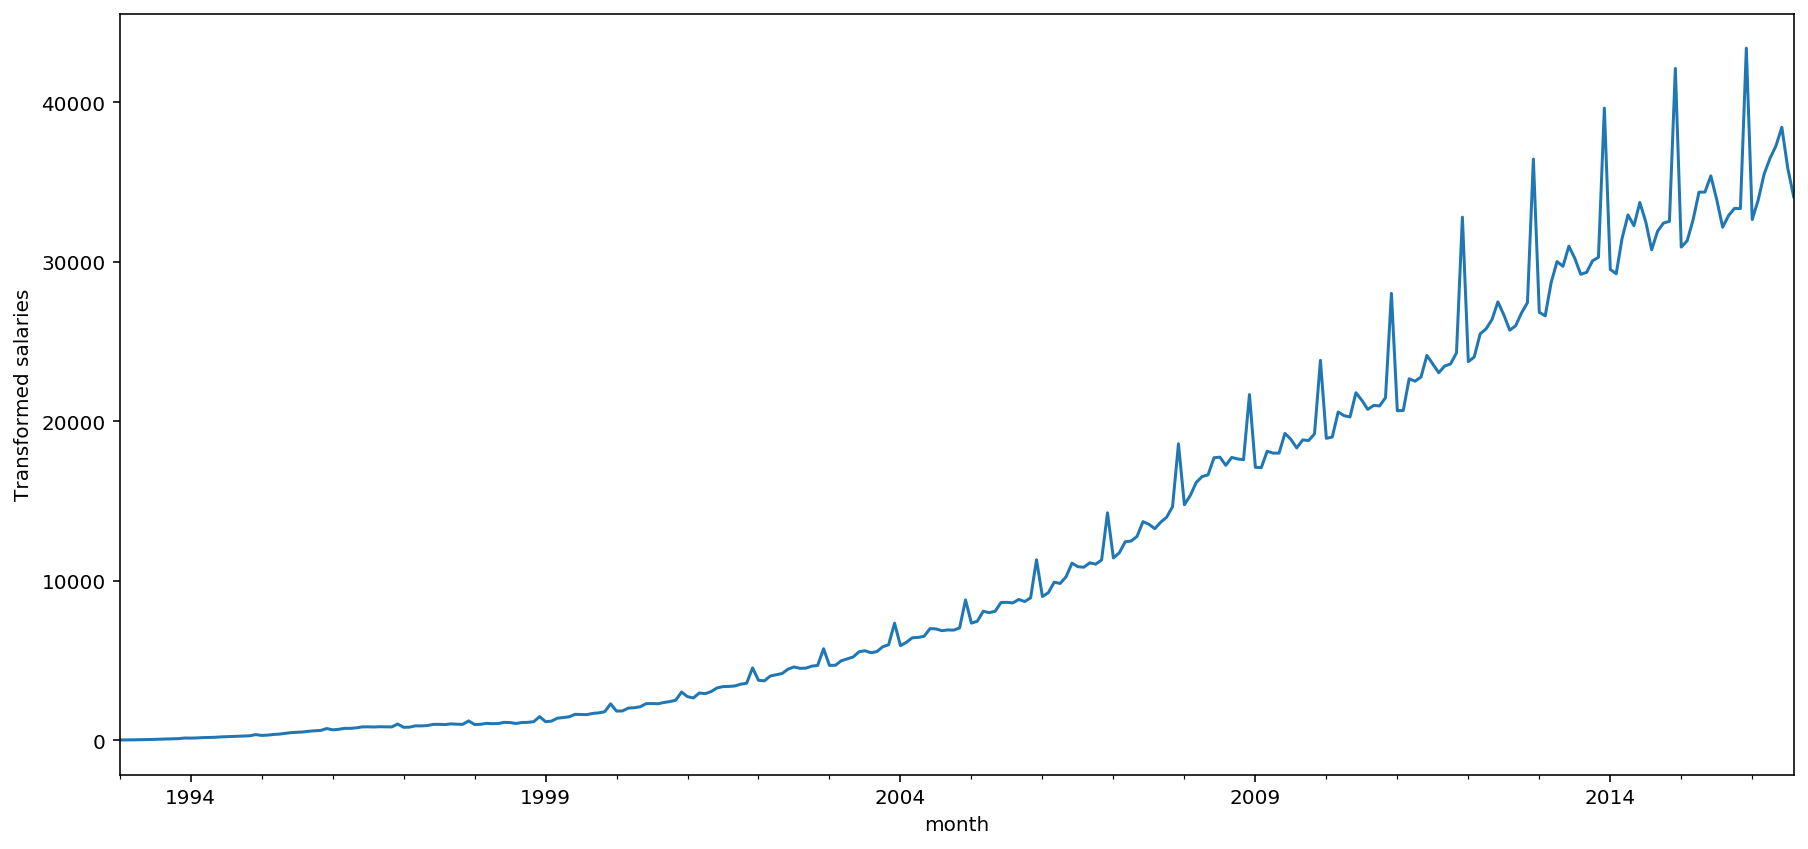

In [19]:
df['salaries_box'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

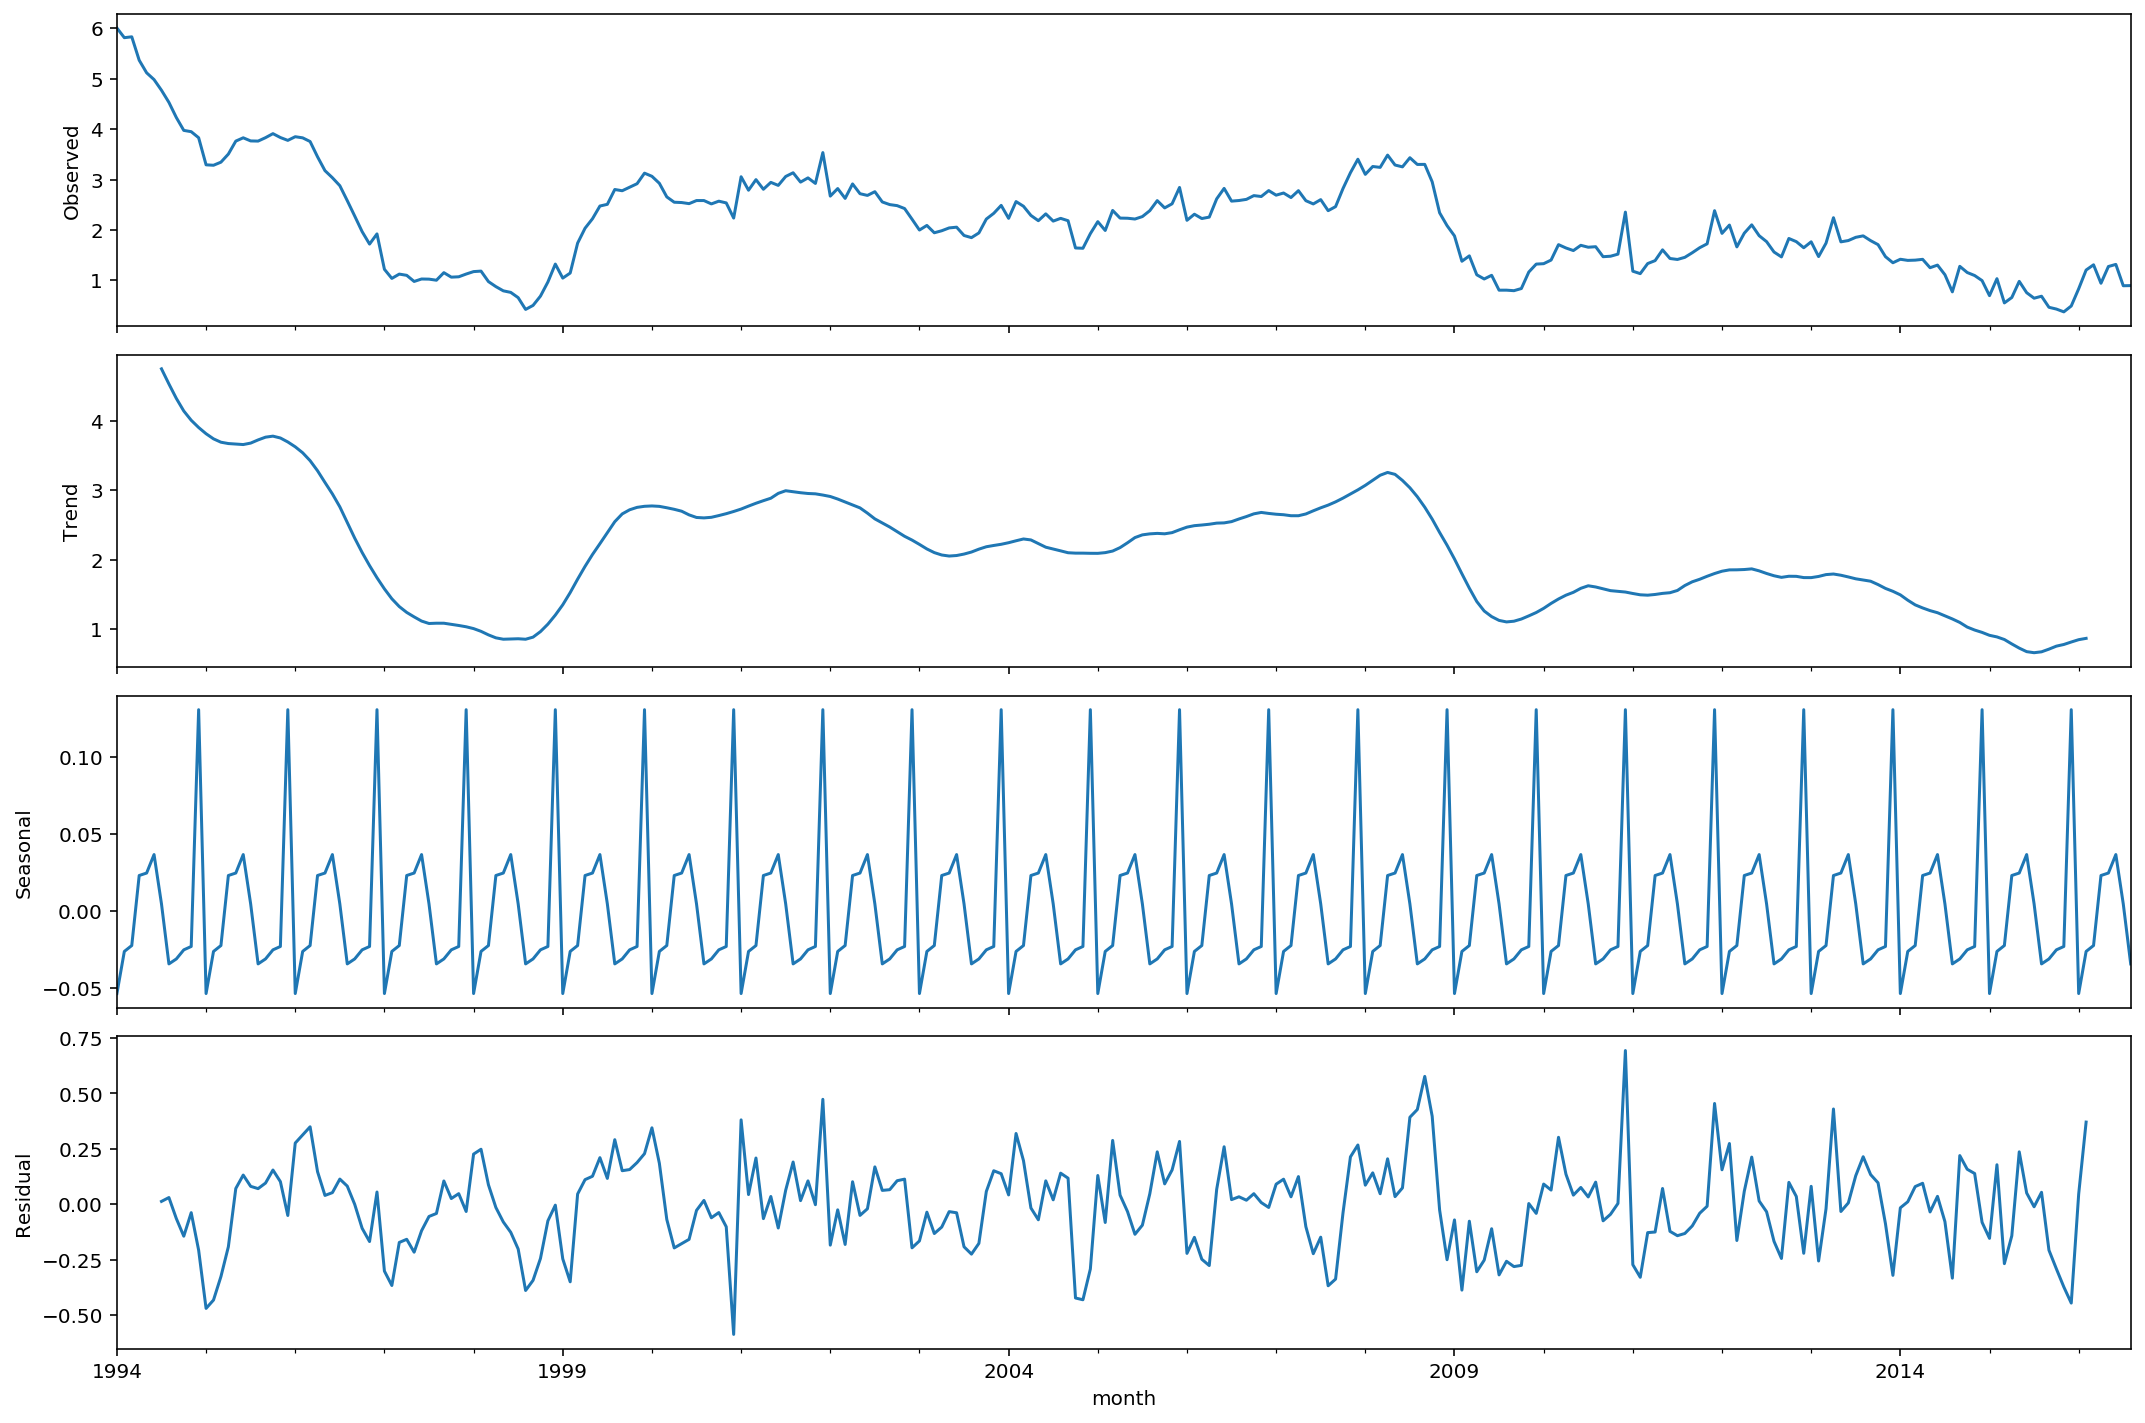

In [22]:
# ничего не вышло, попробуем дифференцирование

df['salaries_box_diff'] = df.salaries_box - df.salaries_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salaries_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salaries_box_diff[12:])[1])

Сезонное диффиринциирование отчасти сработало, тренд пропал, ошибка уменьшилась, гипотиза о нестационарности уверенно отвергается, но сезонность осталась, попробуем продифференцировать еще раз 

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

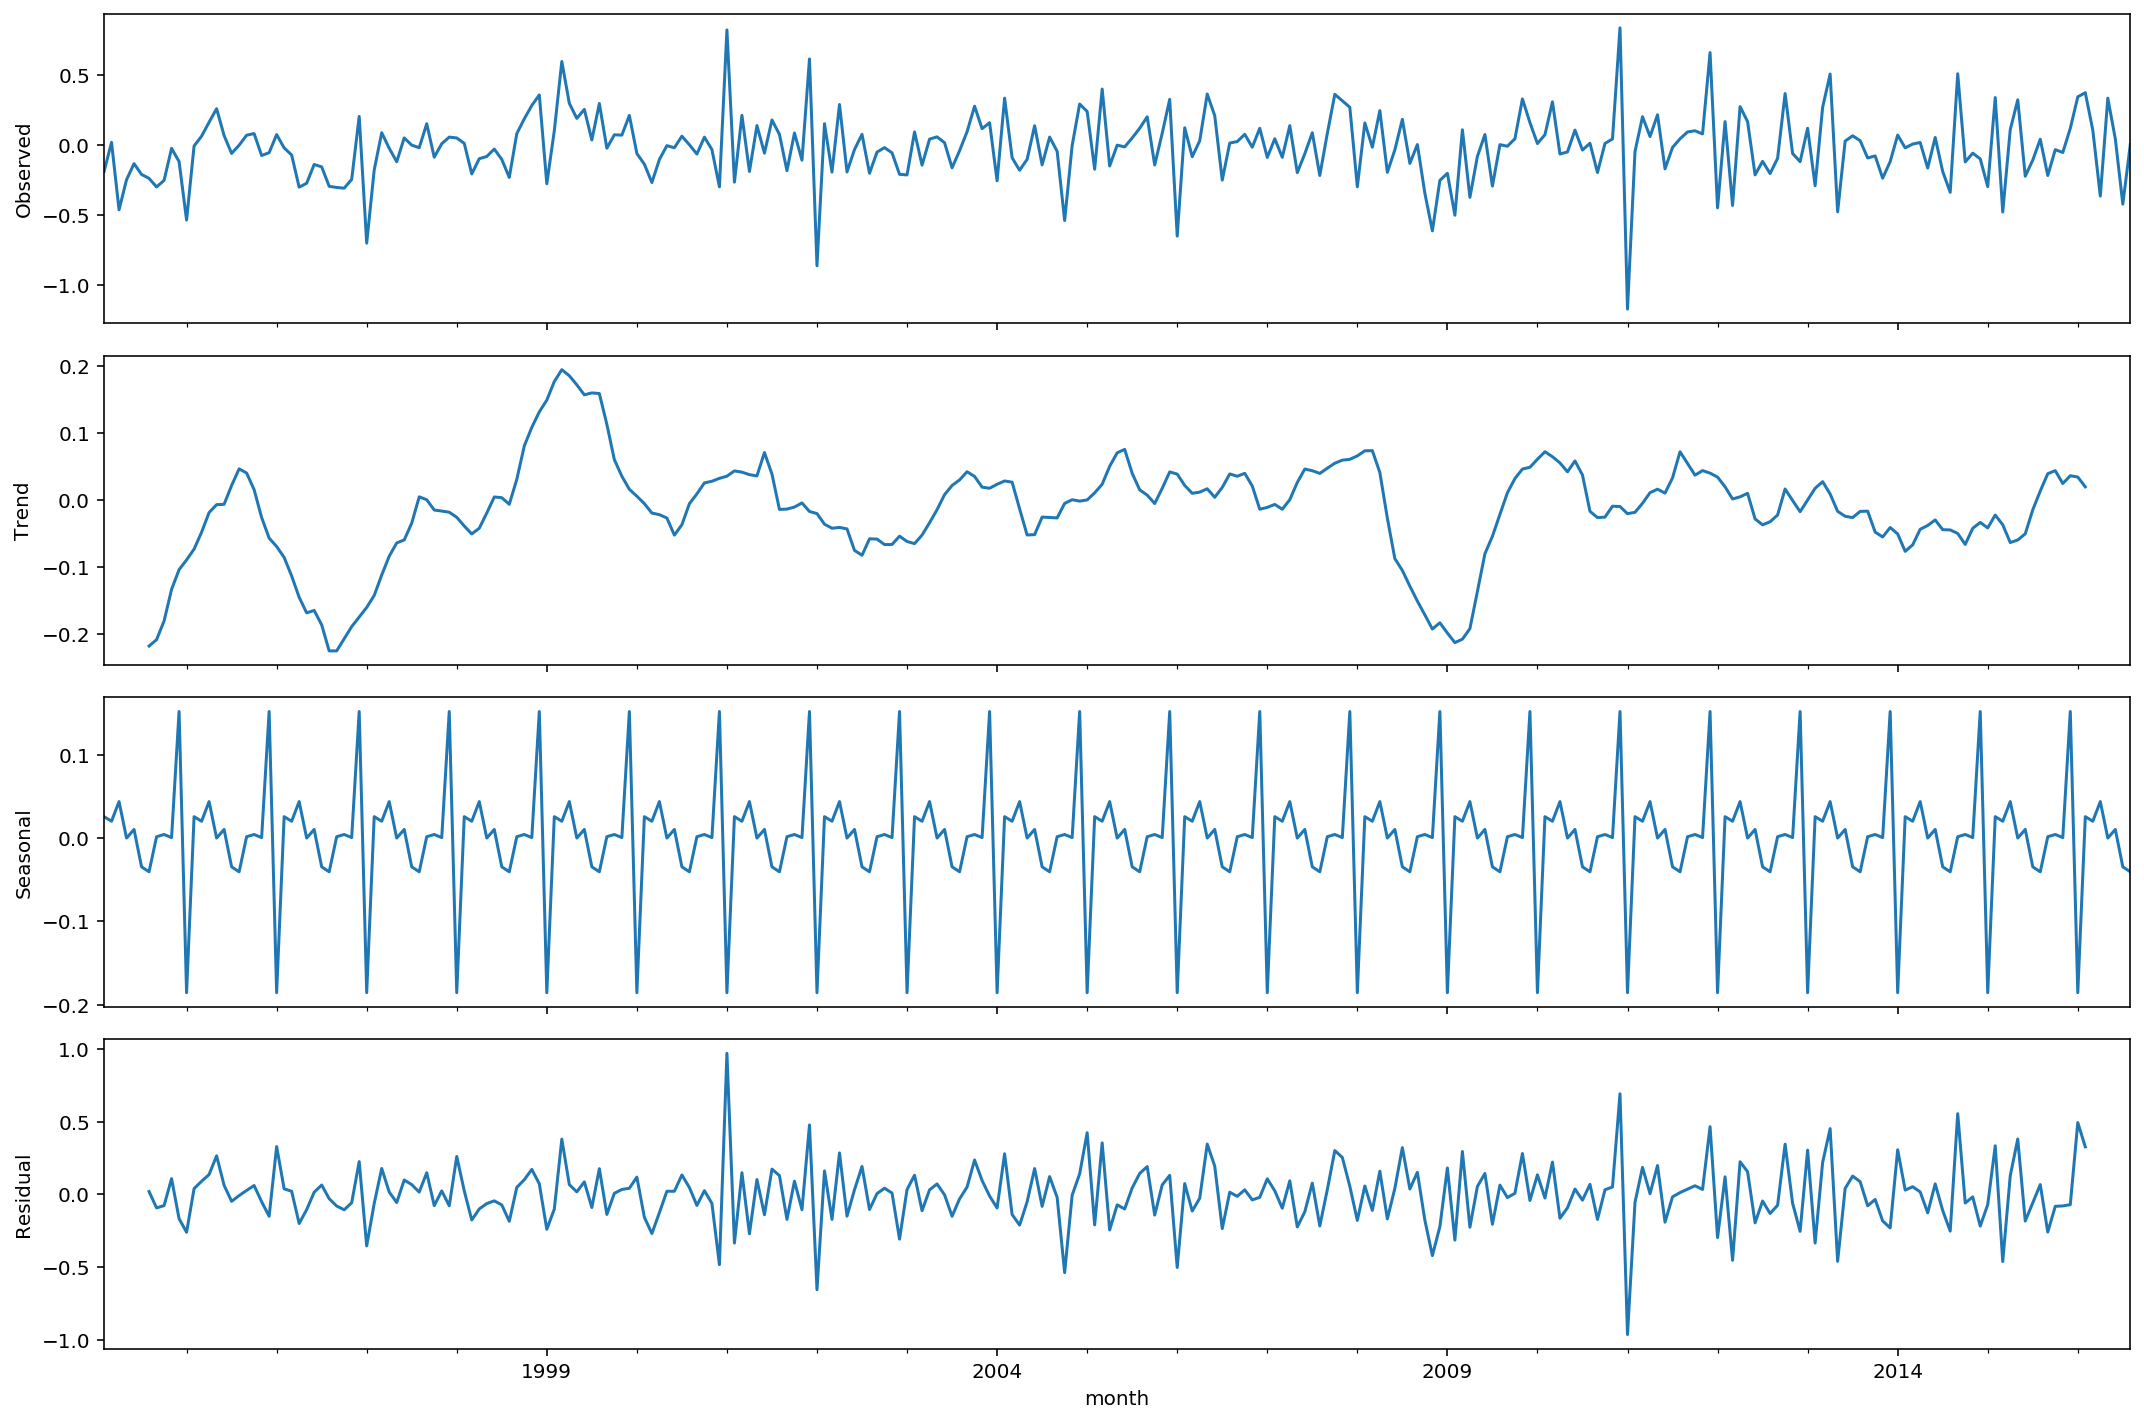

In [28]:
df['salaries_box_diff2'] = df.salaries_box_diff - df.salaries_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.salaries_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.salaries_box_diff2[13:])[1])

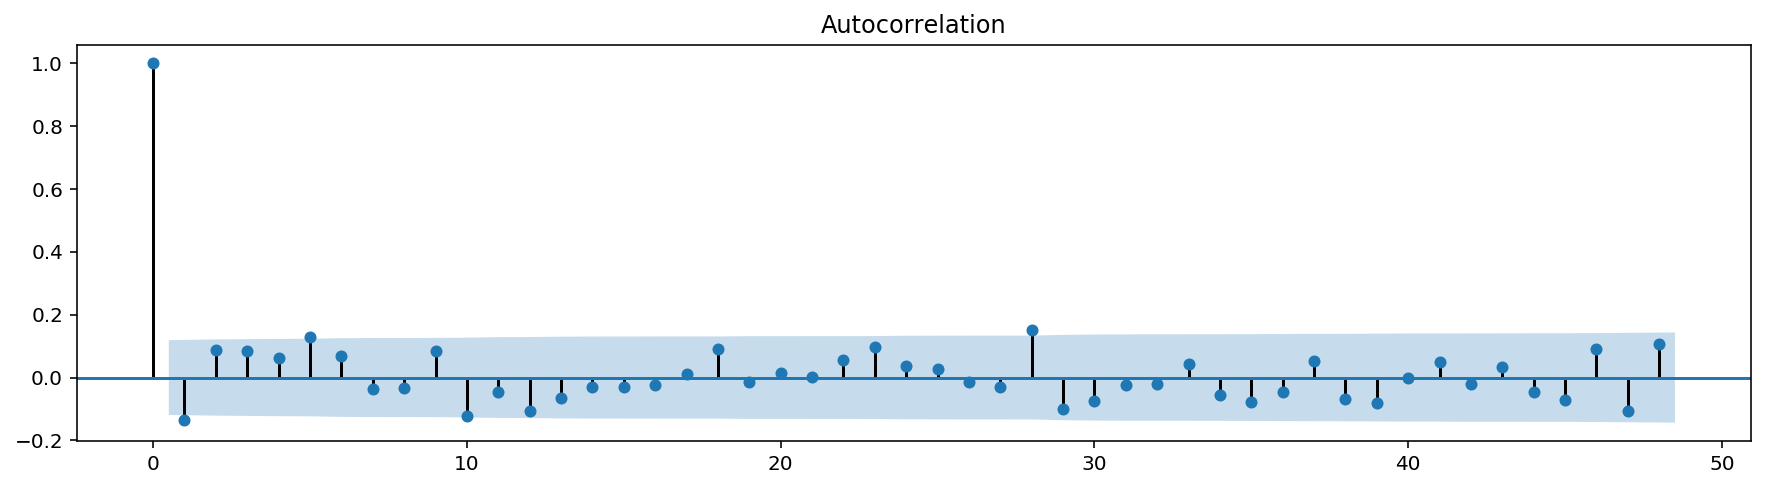

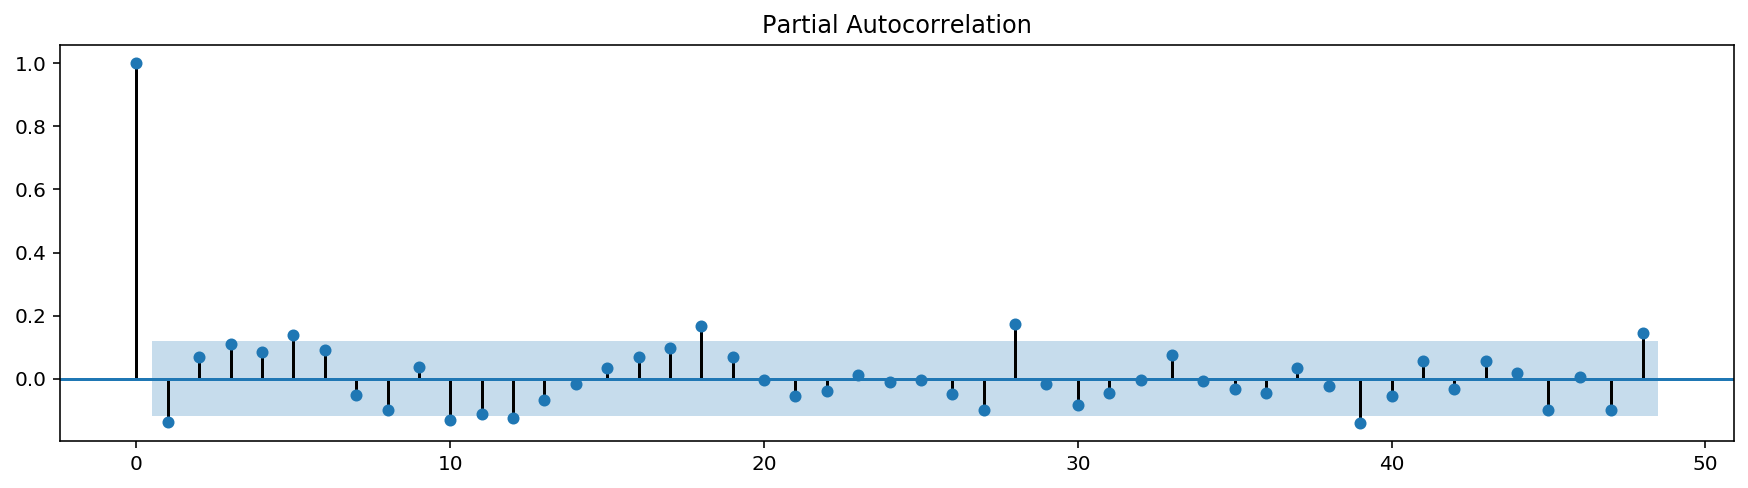

In [30]:
#  Сработало, начнем подбор модели 

plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.salaries_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.salaries_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=0, P=4, p=3

In [125]:
ps = range(0, 4)
d = 1 # тк один раз применяли обычное дифф-е
qs = range(0, 1)
Ps = range(0, 5)
D = 1 # тк один раз применяли сезонное дифф-е
Qs = range(0, 1)

In [126]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


20

In [127]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df.salaries_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 35.4 s, sys: 804 ms, total: 36.2 s
Wall time: 19.1 s


In [128]:
# сравним модели 
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
16  (3, 0, 1, 0) -0.341050
6   (1, 0, 1, 0)  0.340521
17  (3, 0, 2, 0)  0.952055
15  (3, 0, 0, 0)  1.528302
11  (2, 0, 1, 0)  1.533020


In [129]:
# лучшая модель
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       salaries_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   5.171
Date:                            Sat, 25 Jan 2020   AIC                             -0.341
Time:                                    20:07:27   BIC                             17.670
Sample:                                01-01-1993   HQIC                             6.890
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1457      0.046     -3.185      0.001      -0.235      -0.056
ar.L2          0.0718      0.068   

Критерий Стьюдента: p=0.151895
Критерий Дики-Фуллера: p=0.000013


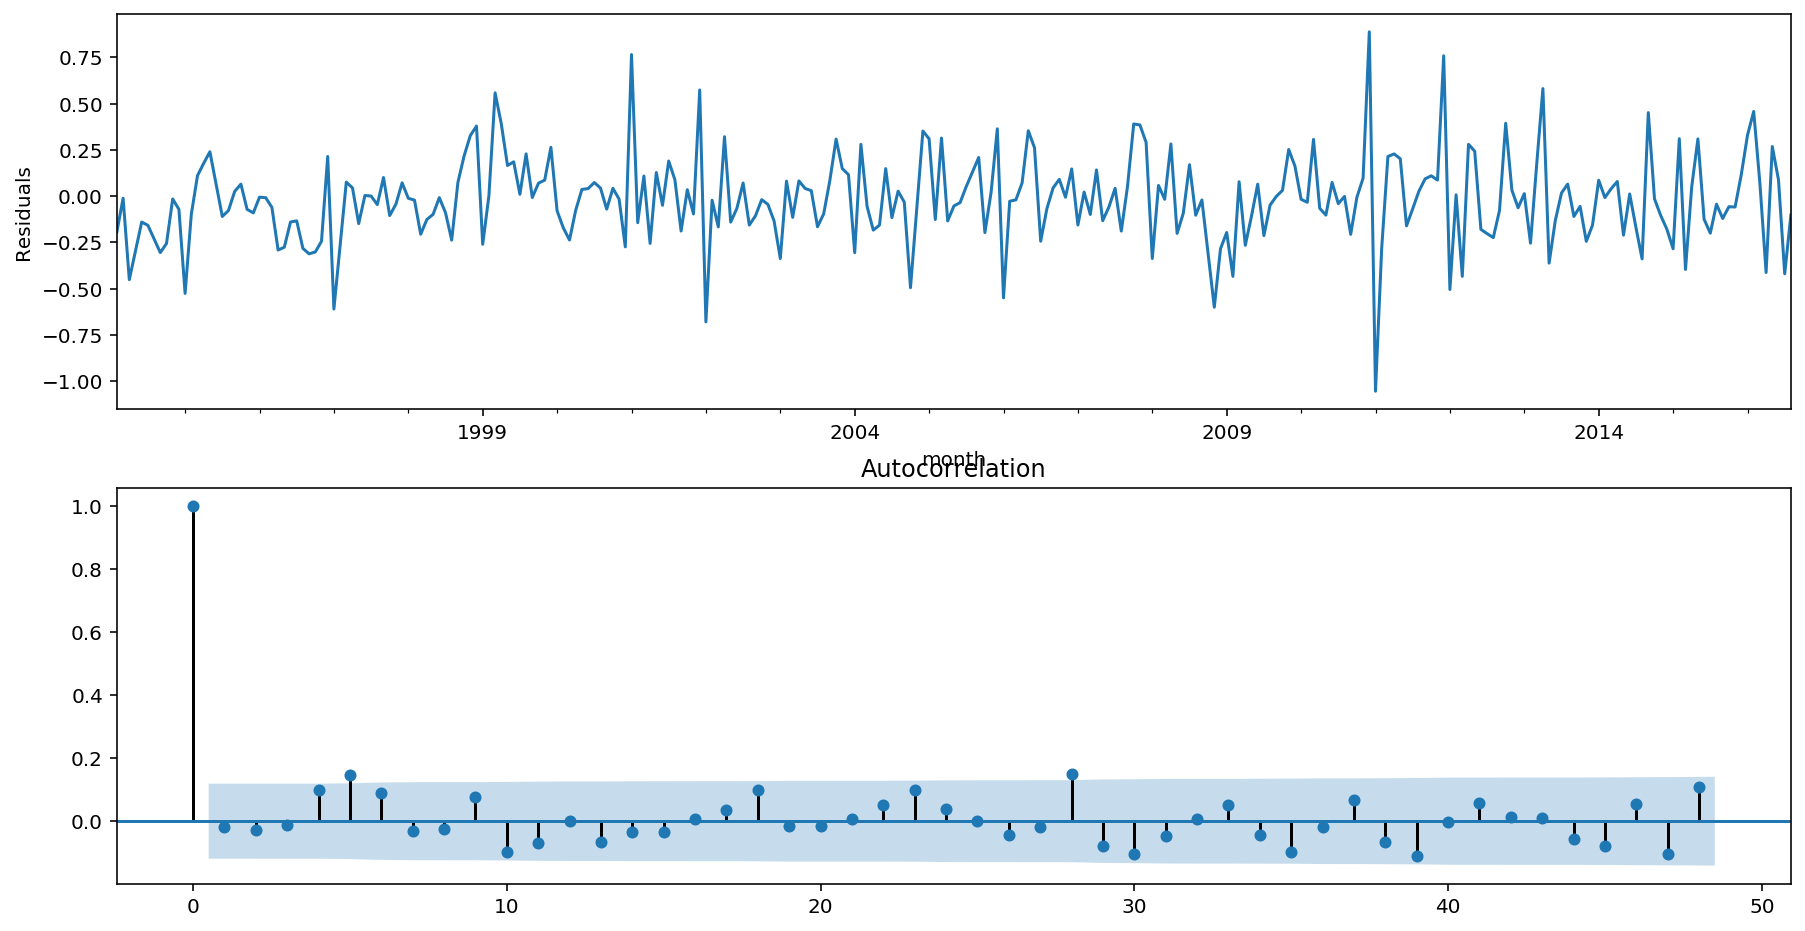

In [130]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается коррелограммой).
    
    
    

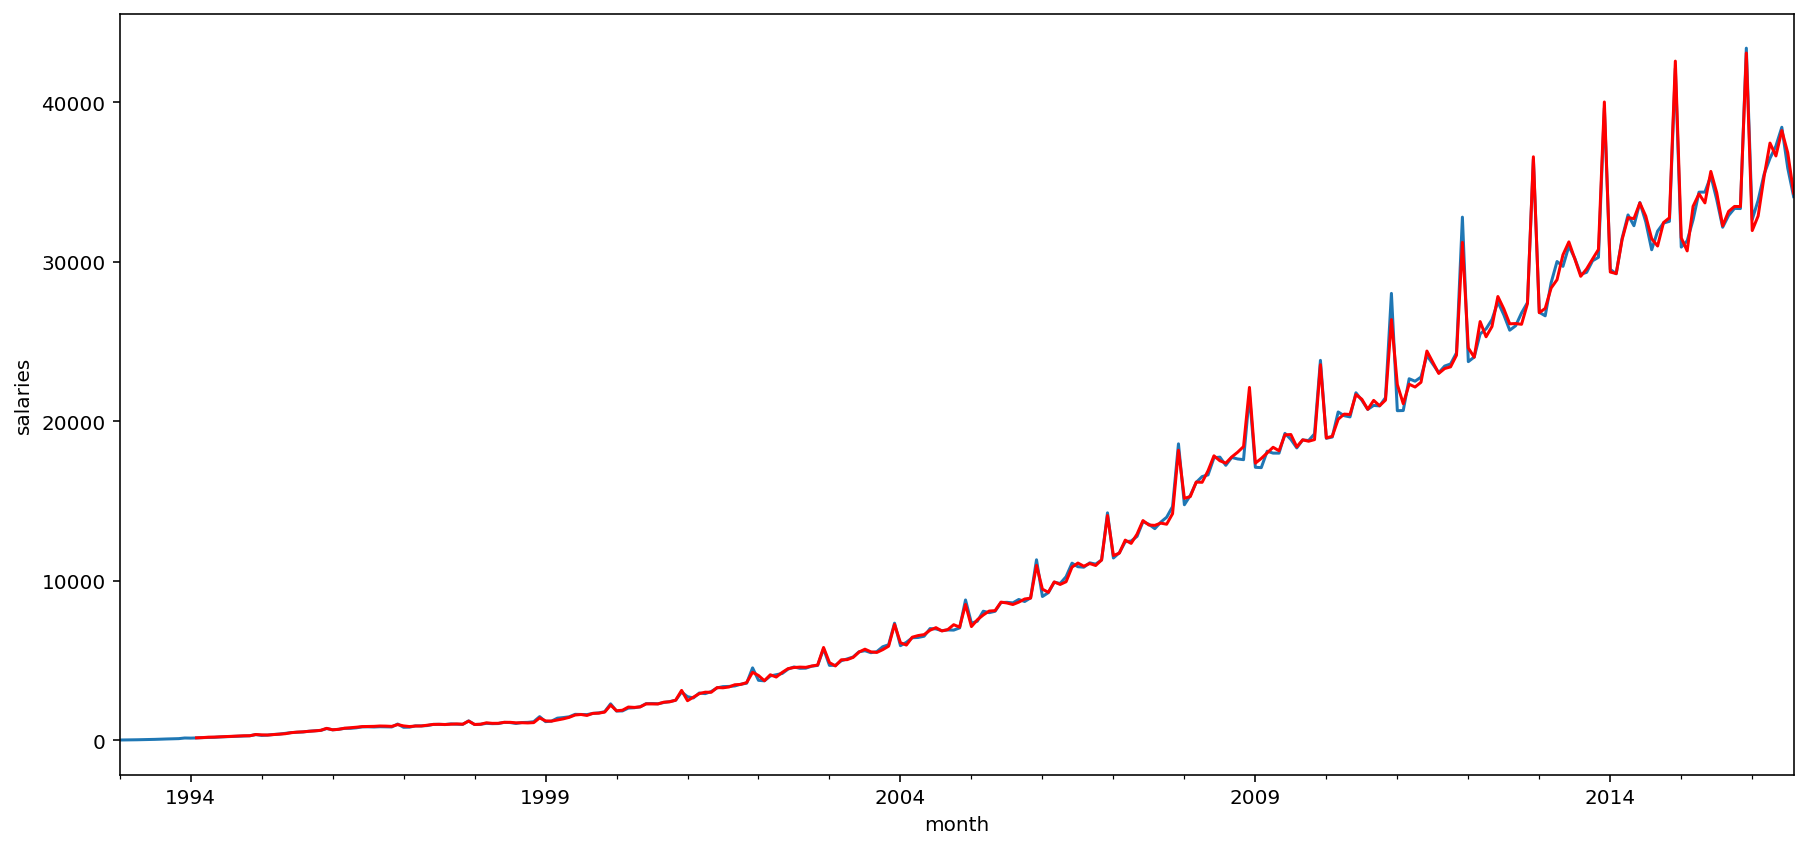

In [131]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.ylabel('salaries')
pylab.show()

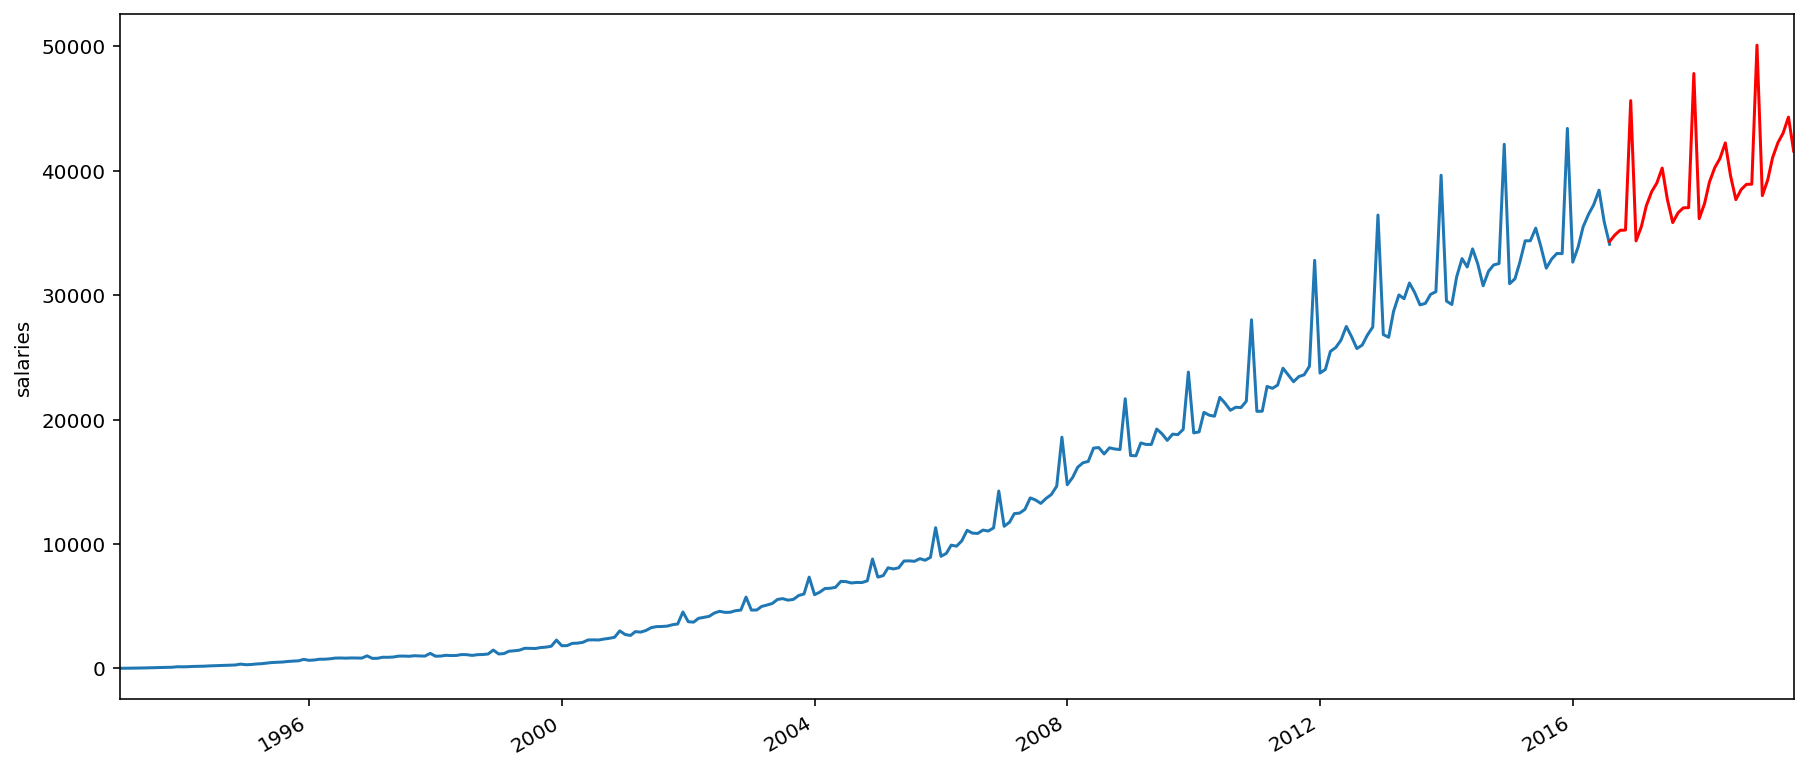

In [132]:
# построим прогноз 

df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=283,end=320), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('salaries')
pylab.show()